<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/apura%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 importações de bibliotecas e recursos

In [2]:
import pandas as pd
import numpy as np
import requests
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import cmath

# 2 funções para fazer as devidas requisições na api

In [3]:
def getDeputadoEstadualUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0007-e000546-r.json'

def getPresidentUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/544/dados-simplificados/{uf}/{uf}-c0001-e000544-r.json'

def getGovernadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0003-e000546-r.json'

def getDeputadoFederalUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0006-e000546-r.json'

def getSenadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0005-e000546-r.json'

gets= [getPresidentUrl, getSenadorUrl, getDeputadoFederalUrl, getDeputadoEstadualUrl, getGovernadorUrl]
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

LULA_TAG          = 'LULA' 
BOLSONARO_TAG     = 'JAIR BOLSONARO' 
CIRO_TAG          = 'CIRO GOMES' 
TEBET_TAG         = 'SIMONE TEBET' 
SORAYA_TAG        = 'SORAYA THRONICKE' 
DAVILA_TAG        =  "FELIPE D'AVILA"
PADRE_TAG         = 'PADRE KELMON' 
SOFIA_MANZANO_TAG = 'SOFIA MANZANO' 
LEO_PERICLES_TAG  ='LÉO PÉRICLES'
VERA_TAG          = 'VERA' 
EYMAEL_TAG        = 'CONSTITUINTE EYMAEL'
candidatesTags    = [LULA_TAG, BOLSONARO_TAG, CIRO_TAG, TEBET_TAG, SORAYA_TAG, DAVILA_TAG, PADRE_TAG, SOFIA_MANZANO_TAG, LEO_PERICLES_TAG, VERA_TAG, EYMAEL_TAG]
candidatesColors   =['red', 'green', 'blue','brown', 'green', 'blue','red', 'green', 'blue','green','yellow']
politicalColors = {}
for i, tag in enumerate(candidatesTags):
  politicalColors[tag] = candidatesColors[i]

# Criação do electionsData
### ele é um objeto mais organizado contendo todas as informações separadas por estado

In [4]:
def takeData(url):
  re=requests.get(url).json()
  candidatos = re['cand']

  df=pd.DataFrame(candidatos)
  df=df[['nm','n','dvt','vap','pvap']]
  df.rename(columns={'nm':'Nome do Candidato',
                  'n':'Numero do Candidato',
                  'dvt':'Validade',
                  'vap':'Votos',
                  'pvap':'(%) Votos'}, inplace=True)
  
  df['(%) Votos']=df['(%) Votos'].str.replace(',','.')
  df['(%) Votos']=df['(%) Votos'].astype(float)
  df['Votos']=df['Votos'].astype(int)
  df['Nome do Candidato']=df['Nome do Candidato'].str.replace('D&apos;',"D'")
  df=df.sort_values(by='Votos', ascending=False)
  return(df)

In [5]:
def getAllDataByUf(uf):
  info = {}
  for index, category in enumerate(categoryKeys):
    try:
      info[category] = takeData(gets[index](uf))
    except:
      if uf == 'df':
        info[category] = 'df não tem prefeito'
      else:
        info[category] = 'this is brasil'
  return info

In [6]:
electionsData = {}
electionsData['br'] = getAllDataByUf('br')
for i, uf in  enumerate(brasil_ufs):
  electionsData[uf] = getAllDataByUf(uf)

In [26]:
def getCandidateScore(uf,candidate, category, attr):
  keysArray = list(electionsData[uf][category].keys()[0:5].array)
  positionOtAttr = keysArray.index(attr)
  usedData = electionsData[uf][category].values
  candidateScore = list(filter(lambda x: x[0]== candidate,usedData))[0][positionOtAttr]
  return candidateScore
getCandidateScore('rj','JAIR BOLSONARO', 'Presidente', '(%) Votos')

51.09

# funções para analizar diferenças entre condidatos

In [7]:
def getDiffBetweenTwoCandidates(uf, category='Presidente', candidates=['JAIR BOLSONARO' , 'LULA'], attr = '(%) Votos'):
  keysArray = list(electionsData[uf][category].keys()[0:5].array)
  positionOtAttr = keysArray.index(attr)
  usedData = electionsData[uf][category].values
  [candidateOne,candidateTwo] = candidates
  candidateOneScore = list(filter(lambda x: x[0]== candidateOne,usedData))[0][positionOtAttr]
  candidateTwoScore = list(filter(lambda x: x[0]== candidateTwo,usedData))[0][positionOtAttr]
  result = float(format(abs(candidateOneScore - candidateTwoScore),'.2f'))
  winer = candidateOne if candidateOneScore > candidateTwoScore else candidateTwo
  return result , winer

In [8]:
getVotesDiffBetweenTwoCandidates = lambda uf,candidates:  getDiffBetweenTwoCandidates(uf=uf , candidates=candidates, attr='Votos')

In [9]:
getPPDiffBetweenTwoCandidates = lambda uf: getDiffBetweenTwoCandidates(uf=uf)

In [10]:
getPPDiffBetweenJairAndLula = lambda uf: getDiffBetweenTwoCandidates(uf=uf)

In [11]:
BIG_NUMBER = 9999999999
def separeDiferents(uf, usedFunc, candidates):
  acrecimo = 0 if usedFunc(uf)[1] ==  candidates[0] else BIG_NUMBER
  return usedFunc(uf)[0] + acrecimo

>função para gerar os graficos comparativos entre os candidatos de maneira genérica, dependendo apenas dos parametros

In [43]:
def showDiffPerState(candidates, attr,category= 'Presidente',mode = 0, aditionalFuncs = []):
  usedFunc = lambda uf :  getDiffBetweenTwoCandidates(uf=uf,candidates=candidates, category=category, attr=attr)
  
  if mode == 0 :
    title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país'
    ordened_ufs = sorted(brasil_ufs,key=lambda uf: usedFunc(uf)[0])
  else:
    title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país separadamente'
    ordened_ufs = sorted(brasil_ufs,key=lambda uf: separeDiferents(uf=uf, usedFunc=usedFunc, candidates=candidates))

  [c1Color, c2color] = [politicalColors[candidates[0]],politicalColors[candidates[1]]]
  baseOrder = (list(map(lambda uf : usedFunc(uf)[0],ordened_ufs)))
  
  ylb = attr
  if attr == 'Votos':
    ylb = 'M votos'
    counts = (list(map(lambda x : float(format(abs(x/1000000),'.2f')),baseOrder)))
  else:
    counts = baseOrder
  bar_colors = list(map(lambda uf : f'tab:{c1Color}' if usedFunc(uf)[1] == candidates[0] else f'tab:{c2color}',ordened_ufs))

  fig, ax = plt.subplots()

  for func in aditionalFuncs:
    func(ax=ax,ordened_ufs=ordened_ufs)

  ax.bar(ordened_ufs, counts, color = bar_colors)
  ax.bar([0], [0], color = c1Color, label=f'onde {candidates[0]} ganhou') #metodo para conseguir colocar a legenda
  ax.bar([0 ],[0 ], color = c2color, label=f'onde {candidates[1]} ganhou')
  # bar_colors = list(map(lambda uf : getPPDiffBetweenJairNine(uf)[1],ordened_ufs))
  fig.set_size_inches(16,8)
  ax.set_ylabel(ylb)
  ax.set_xlabel('estados')
  ax.set_title(title)
  ax.legend()
  plt.rcParams.update({'font.size': 15})
  return plt.show

<function matplotlib.pyplot.show(*args, **kw)>

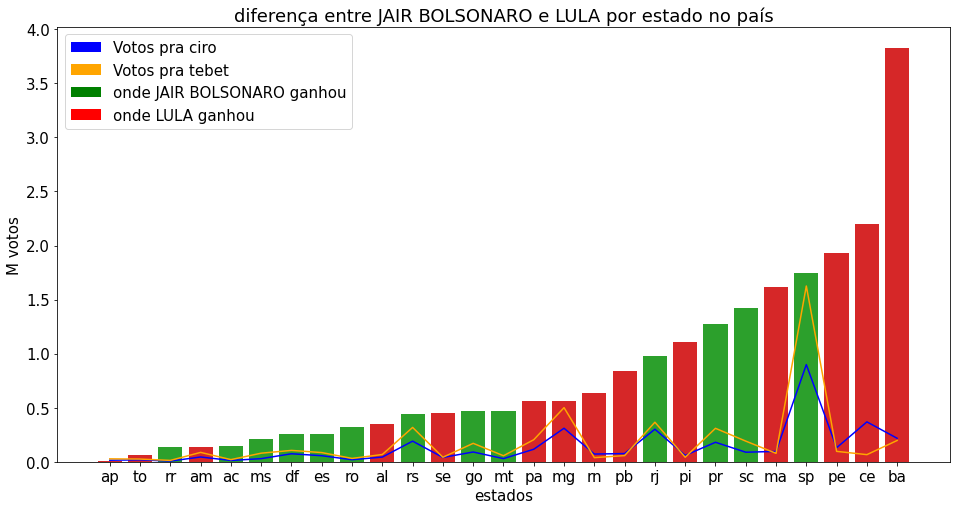

In [48]:
def test1(ax,ordened_ufs):
  counts = list(map( lambda uf: getCandidateScore(uf=uf,category='Presidente', candidate='CIRO GOMES', attr= 'Votos')/1000000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'blue', label=f'Votos pra ciro')
  ax.plot(ordened_ufs,counts, color = 'blue')
def test2(ax,ordened_ufs):
  counts = list(map( lambda uf: getCandidateScore(uf=uf,category='Presidente', candidate='SIMONE TEBET', attr= 'Votos')/1000000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'orange', label=f'Votos pra tebet')
  ax.plot(ordened_ufs,counts, color = 'orange')

showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='Votos',mode = 0, aditionalFuncs=[test1,test2])

# Os Graficos Começam daqui pra baixo

A seguir está o grafico da diferença entre os candidatos (em porcentagem por cada região)

Podemos perceber a liderança do Píaui e Roraima respectivamente como o mais "lulistas" e "bolsonaristas" do país, entretanto a quantidade numérica de votos não expressa o mesmo

<function matplotlib.pyplot.show(*args, **kw)>

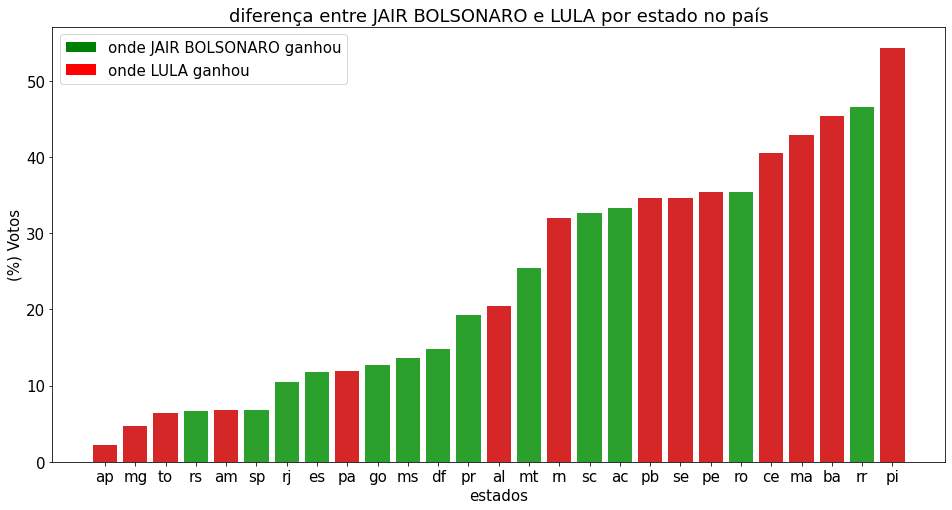

In [45]:
showDiffPerState(category='Presidente', candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 0)

>mesmo grafico porém melhor organizado, tendo os estados divididos entre os que Bolsonaro e Lula ganharam respectivamente

<function matplotlib.pyplot.show(*args, **kw)>

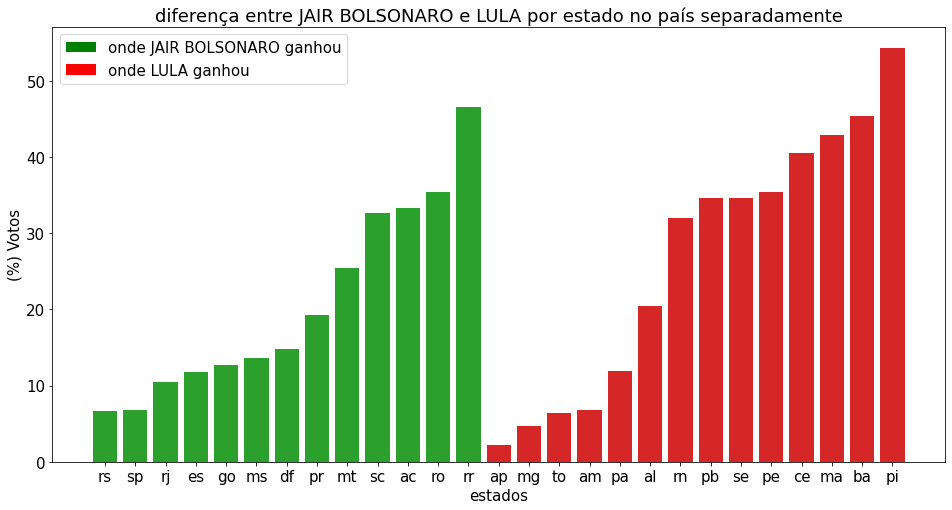

In [14]:
showDiffPerState(category='Presidente', candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1)

Aqui podemos perceber que a expressividade proporcional do gráfico anterior engana

>Píaui (PI), mesmo sendo o que tem mais "lulistas" proporcionalmente, não foi o que conseguiu mais votos para lula, e sim a Bahia, tendo o segundo lugar em porcentagem de "lulistas" no território

>São Paulo (SP) torna essa diferença ainda mais nitida, proporcionalmente ele é o segundo **menos** bolsonarista, mas é o que conseguiu mais voto para o candidato

<function matplotlib.pyplot.show(*args, **kw)>

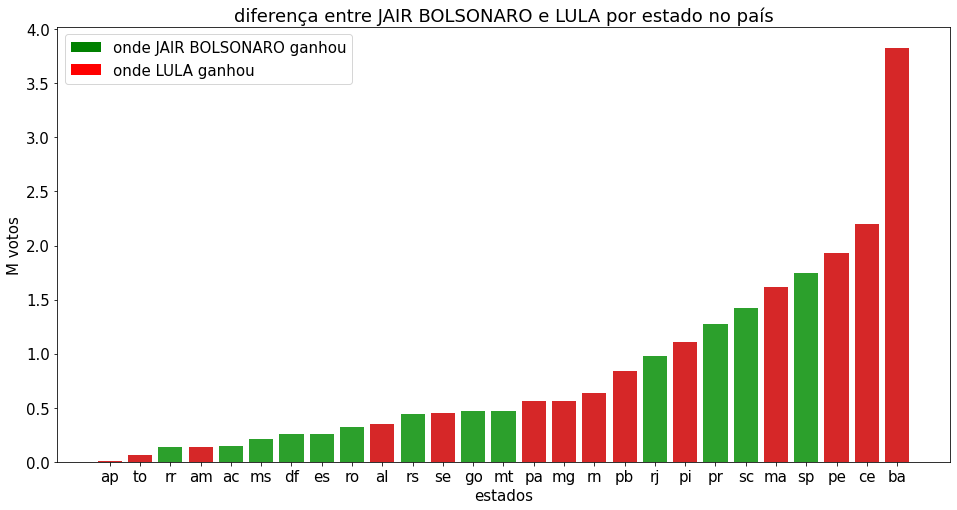

In [15]:
showDiffPerState(category='Presidente', candidates = [BOLSONARO_TAG,LULA_TAG], attr='Votos',mode = 0)

Com o Ciro e a Tebet percebe se a mesma coisa acontecendo de maneira ainda mais gritante no Ceará (CE), estado no qual ele foi governador

<function matplotlib.pyplot.show(*args, **kw)>

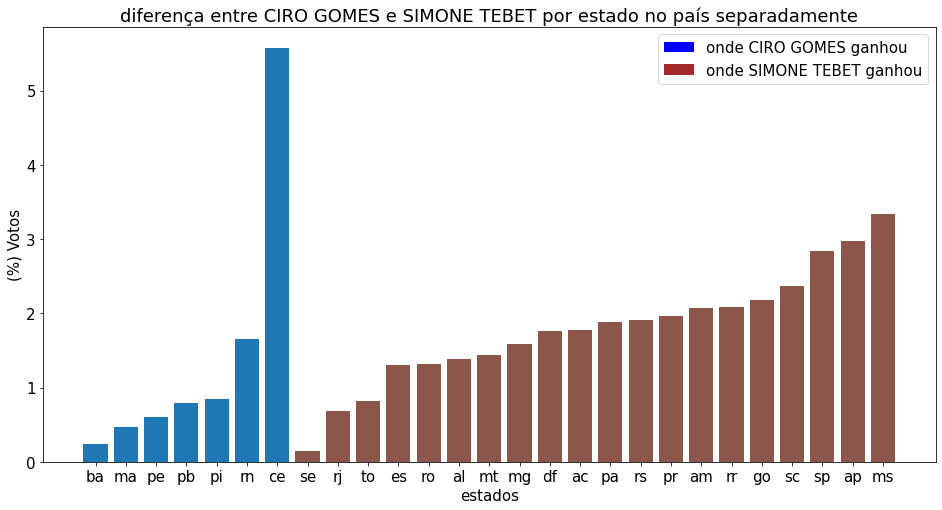

In [16]:
showDiffPerState(category='Presidente', candidates = [CIRO_TAG,TEBET_TAG], attr='(%) Votos',mode = 1)

<function matplotlib.pyplot.show(*args, **kw)>

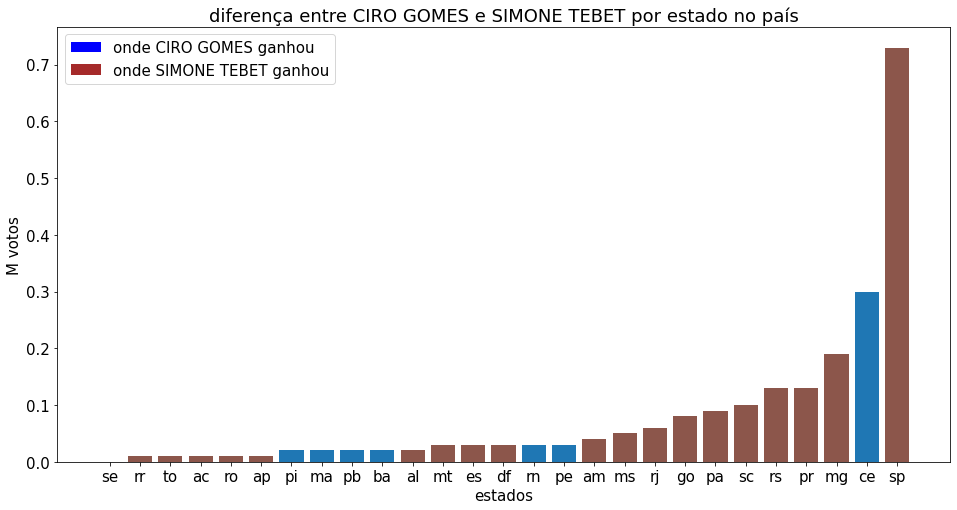

In [17]:
showDiffPerState(category='Presidente', candidates = [CIRO_TAG,TEBET_TAG], attr='Votos',mode = 0)